In [1]:
%matplotlib inline

import os
import random
import time
import datetime
import copy
from decimal import Decimal, ROUND_HALF_UP

from netpyne import specs, sim
import matplotlib.pyplot as plt
import numpy as np
from netpyne import specs, sim
from neuron import h
import pandas as pd
from tqdm import tqdm
from scipy.stats import entropy, differential_entropy

### SETTINGS ##################

read_folder = 'Ground truth SWCs/Small'
simplify = False
SEED = 0
cells = 50

square_size = 100

sigma_gnabars = np.linspace(0., 0.3, num=square_size)
mu_gnabars = np.linspace(0.05, 0.6, num=square_size)

data = np.zeros((square_size, square_size))
entropies = np.zeros((square_size, square_size))

impulse_delay = 10 #ms
microscope_recording_duration = 0.150*1e3  #ms

netParams = specs.NetParams()

### Data storage arrays ##########
swc_filenames = []
for file in os.listdir(read_folder):
    if os.path.splitext(file)[-1] == '.swc':
        swc_filenames.append(file)

swcs = []
for ii in range(cells):
    swc_fname = random.choice(swc_filenames)
    swcs.append(swc_fname)

masterCellRules = []
cell_labels = []
for ii in range(cells):
    swc_fname = swcs[ii]

    label = f'trace_{ii:04d}'
    cell_labels.append(label)
    
    masterCellRule = netParams.importCellParams(
                        label=label, 
                        conds={'cellType': label},
                        fileName=os.path.join(read_folder, swc_fname), 
                        cellName=label,
                        )
    
    # For convenience, we'll rename the first soma section in the morphology from `soma_0` to `soma`.
    netParams.renameCellParamsSec(label, 'soma_0', 'soma')
    
    netParams.sizeZ = 10

    masterCellRules.append(masterCellRule)
    
## Synaptic mechanism parameters
netParams.synMechParams['exc'] = {'mod': 'Exp2Syn', 'tau1': 0.8, 'tau2': 5.3, 'e': 0}  # NMDA synaptic mechanism
netParams.synMechParams['inh'] = {'mod': 'Exp2Syn', 'tau1': 0.6, 'tau2': 8.5, 'e': -75}  # GABA synaptic mechanism

netParams.stimSourceParams[f'Probe'] = {'type': 'IClamp', 'del': impulse_delay, 'dur': 300, 'amp': 5}
for label in cell_labels:
    netParams.stimTargetParams[f'Probe->{label}'] = {'source': 'Probe', 
                                                 'sec': 'soma',
                                                 'loc': 0.5,
                                                 'conds': {'cellType': label}}

# Simulation options
simConfig = specs.SimConfig()        # object of class SimConfig to store simulation configuration

simConfig.duration = 0.150*1e3           # Duration of the simulation, in ms
simConfig.dt = 0.005                 # Internal integration timestep to use
simConfig.verbose = False            # Show detailed messages
simConfig.recordTraces = {'V_soma':{'sec':'soma','loc':0.5,'var':'v'}}  # Dict with traces to record
simConfig.recordCells = range(cells)
simConfig.recordStep = 0.25             # Step size in ms to save data (e.g. V traces, LFP, etc)
simConfig.hParams['celsius'] = 20
simConfig.analysis['plotSpikeStats'] = {'stats' : ['rate'],
                                       'showFig' : False}

random.seed(SEED)
            


X = np.zeros(cells)
Y = np.zeros(cells)
Z = np.zeros(cells)

size = np.ceil(np.sqrt(cells)).astype(int)
for ii in range(cells):
    rel_coords = np.array([np.floor(ii / size), ii % size])
    rel_coords = rel_coords + 1
    rel_coords = rel_coords / (size + 2)

    X[ii] = netParams.sizeX * rel_coords[0]
    Y[ii] = netParams.sizeY * rel_coords[1]
    Z[ii] = netParams.sizeZ * 0.5

In [ ]:
with tqdm(total=square_size**2) as pbar:
    for uu, sigma_gnabar in enumerate(sigma_gnabars):
        for vv, mu_gnabar in enumerate(mu_gnabars):

            ###########################
            
            
            gnabars = np.random.normal(mu_gnabar, sigma_gnabar, cells)

            for ii, (label, cellRule) in enumerate(zip(cell_labels, masterCellRules)):
                
                for secName in cellRule['secs']:
                    cellRule['secs'][secName]['geom']['cm'] = 1
                    cellRule['secs'][secName]['mechs']['hh'] = {
                        'gnabar': gnabars[ii], 
                        'gkbar': 0.036, 
                        'gl': 0.003, 
                        'el': -70,
                        }
              
                netParams.popParams[label] = {'cellType'  : label,
                                              'cellModel' : 'HH3D', 
                                              'numCells'  : 1,
                                              'xRange'    : [X[ii]-1, X[ii]+1], 
                                              'yRange'    : [Y[ii]-1, Y[ii]+1], 
                                              'zRange'    : [Z[ii]-1, Z[ii]+1], }


            # Create network and run simulation
            sim.createSimulateAnalyze(netParams = netParams, simConfig = simConfig)

            spike_times = np.array(sim.simData['spkt'])
            spike_ids = np.array(sim.simData['spkid']).astype(int)

            spike_freq = np.zeros(cells)

            for tt, sid in zip(spike_times, spike_ids):
                spike_freq[sid] = spike_freq[sid] + 1

            spike_freq =  spike_freq / (microscope_recording_duration) * 1000
      
            
            spike_entropy = differential_entropy(spike_freq, base=2)
            entropies[uu, vv] = spike_entropy


            unique_spike_freqs = len(np.unique(spike_freq))
            data[uu, vv] = unique_spike_freqs
            pbar.update(1)
            
            print(f'Found {unique_spike_freqs} unique freqs. Entropy: {spike_entropy}')

In [3]:
cellRule

{conds: {cellType: 'trace_0049'}, secs: {dend_0: {geom: {L: 17.04443846494141, nseg: 1, diam: 2.163416833226963, Ra: 35.4, cm: 1, pt3d: [(-9.4399995803833, -2.3399999141693115, 0.0, 2.2339999675750732), (-11.210000038146973, -2.9000000953674316, 0.0, 2.2179999351501465), (-12.520000457763672, -3.240000009536743, 0.0, 1.2740000486373901), (-13.229999542236328, -3.0999999046325684, 0.0, 1.50600004196167), (-14.680000305175781, -3.0799999237060547, 0.0, 1.9880000352859497), (-16.329999923706055, -2.4600000381469727, 0.0, 2.2179999351501465), (-17.530000686645508, -2.3299999237060547, 0.0, 2.2179999351501465), (-18.780000686645508, -2.2699999809265137, 0.0, 2.2179999351501465), (-20.040000915527344, -2.240000009536743, 0.0, 2.2179999351501465), (-21.40999984741211, -2.4100000858306885, 0.0, 1.9119999408721924), (-22.8799991607666, -2.8399999141693115, 0.0, 1.9880000352859497), (-25.440000534057617, -4.869999885559082, 0.0, 3.549999952316284)]}, topol: {parentSec: 'soma', parentX: 0.5, chil

In [4]:
np.save('data.npy', data)
np.save('entropy.npy', entropies)
entropies

array([[      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       [      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       [      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       ...,
       [      -inf,       -inf,       -inf, ..., 7.94173584, 7.97314385,
        7.96102389],
       [      -inf,       -inf,       -inf, ..., 7.79178632, 7.98507487,
        7.79751724],
       [      -inf,       -inf,       -inf, ..., 7.86691317,       -inf,
              -inf]])

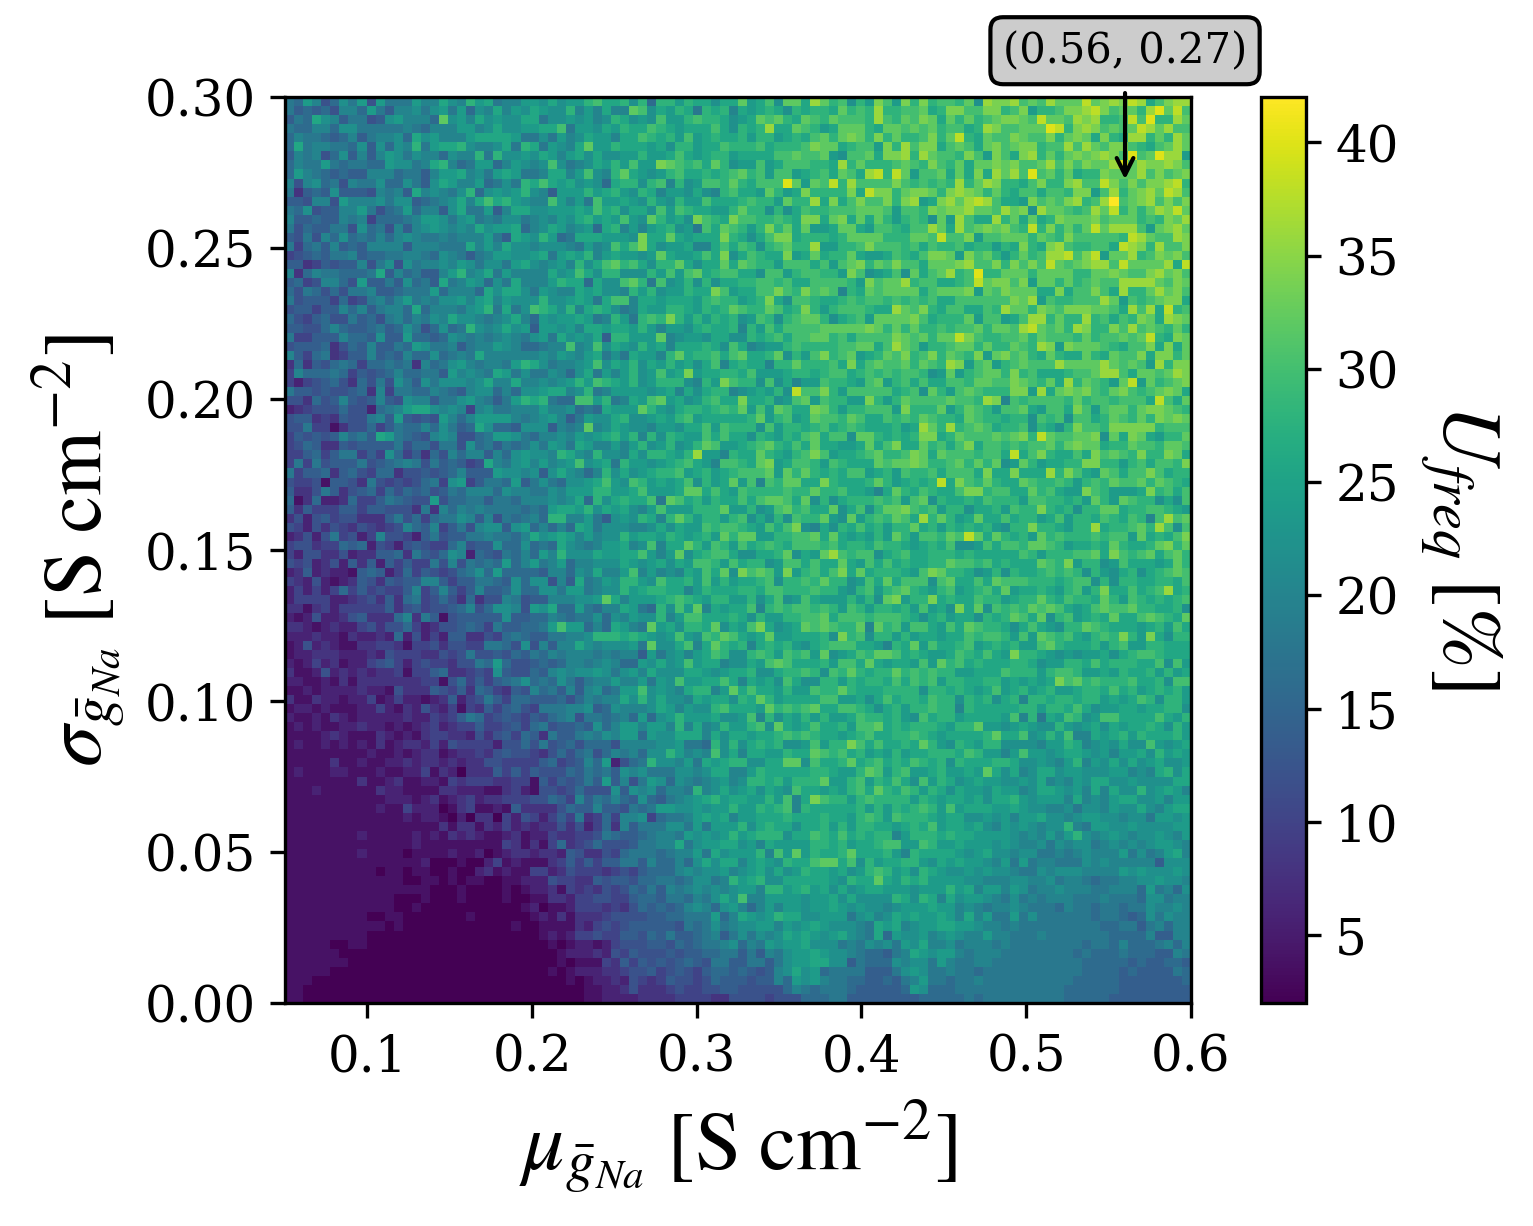

<Figure size 432x288 with 0 Axes>

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Cambria Math"] + plt.rcParams["font.serif"]

fig = plt.figure(1, dpi=300)
ax = fig.add_subplot(111, autoscale_on=False)
ax.set_xlim(left=mu_gnabars[0], right=mu_gnabars[-1])
ax.set_ylim(bottom=sigma_gnabars[0], top=sigma_gnabars[-1])

aspect = (mu_gnabars[-1] - mu_gnabars[0]) / (sigma_gnabars[-1] - sigma_gnabars[0])
plt.imshow(data/cells*100, 
           extent=[mu_gnabars[0], mu_gnabars[-1], sigma_gnabars[-1], sigma_gnabars[0]], 
           aspect=aspect,)
plt.ylabel(r'$\sigma_{\bar{g}_{Na}}\;\mathrm{[S\;cm}^{-2}\mathrm{]}$', fontsize=20)
plt.xlabel(r'$\mu_{\bar{g}_{Na}}\;\mathrm{[S\;cm}^{-2}\mathrm{]}$', fontsize=20)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_ylabel('$U_{freq}\;\mathrm{ [\%]}$ ', rotation=270, fontsize=20)

max_idx = np.unravel_index(np.argmax(data), data.shape)
max_pos = np.round((mu_gnabars[max_idx[1]], sigma_gnabars[max_idx[0]]),2)

ax.annotate(f"{tuple(max_pos)}", # this is the text
                 max_pos, # these are the coordinates to position the label
               arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 bbox=dict(boxstyle="round", fc="0.8"),
                 ha='center')

mu_gnabars[max_idx[1]]
plt.show()
plt.savefig('unique_freqs.png')

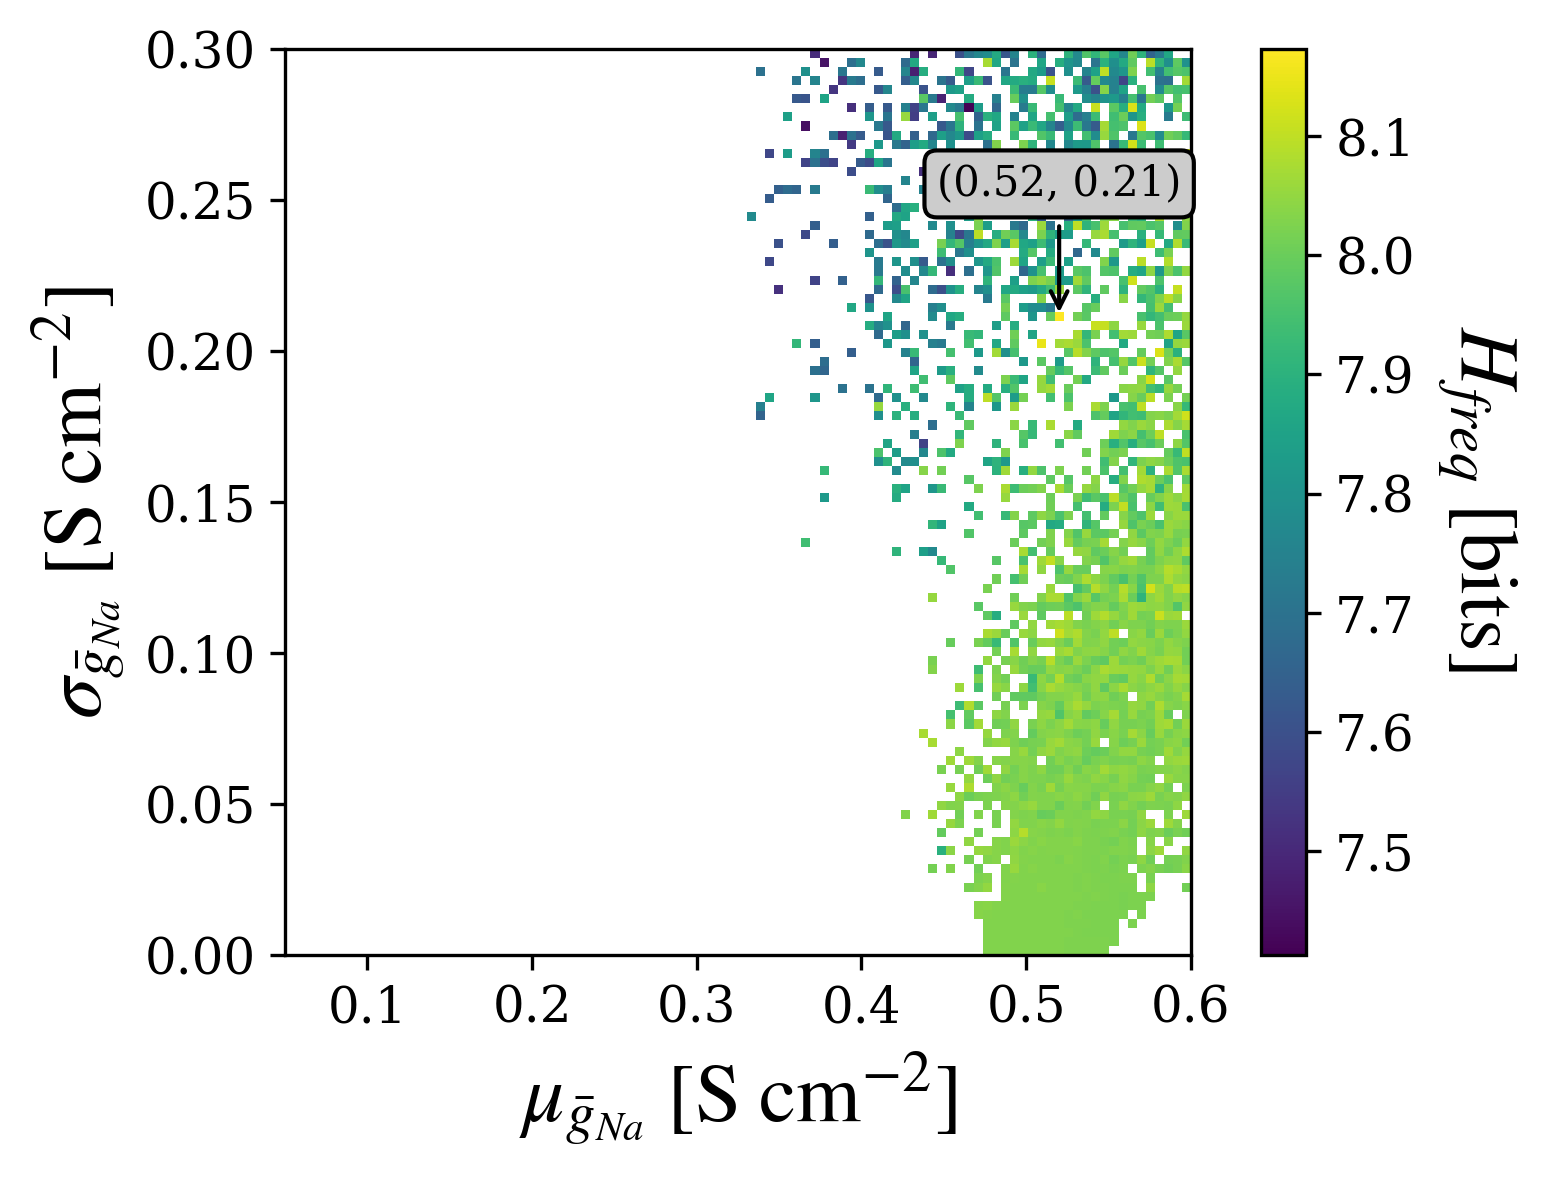

<Figure size 432x288 with 0 Axes>

In [9]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# rc = {"font.family" : "serif", 
#       "mathtext.fontset" : "stix"}
# plt.rcParams.update(rc)
# plt.rcParams["font.serif"] = ["Cambria Math"] + plt.rcParams["font.serif"]

fig = plt.figure(2, dpi=300)
ax = fig.add_subplot(111, autoscale_on=False)
ax.set_xlim(left=mu_gnabars[0], right=mu_gnabars[-1])
ax.set_ylim(bottom=sigma_gnabars[0], top=sigma_gnabars[-1])

aspect = (mu_gnabars[-1] - mu_gnabars[0]) / (sigma_gnabars[-1] - sigma_gnabars[0])
plt.imshow(entropies, 
           extent=[mu_gnabars[0], mu_gnabars[-1], sigma_gnabars[-1], sigma_gnabars[0]], 
           aspect=aspect,)
plt.ylabel(r'$\sigma_{\bar{g}_{Na}}\;\mathrm{[S\;cm}^{-2}\mathrm{]}$', fontsize=20)
plt.xlabel(r'$\mu_{\bar{g}_{Na}}\;\mathrm{[S\;cm}^{-2}\mathrm{]}$', fontsize=20)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_ylabel('$H_{freq}\;\mathrm{ [bits]}$ ', rotation=270, fontsize=20)

max_idx = np.unravel_index(np.argmax(entropies), entropies.shape)
max_pos = np.round((mu_gnabars[max_idx[1]], sigma_gnabars[max_idx[0]]),2)

ax.annotate(f"{tuple(max_pos)}", # this is the text
                 max_pos, # these are the coordinates to position the label
               arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 bbox=dict(boxstyle="round", fc="0.8"),
                 ha='center')

mu_gnabars[max_idx[1]]
plt.show()
plt.savefig('entropy.png')

In [7]:
entropies_clipped * np.isfinite(entropies)


NameError: name 'entropies_clipped' is not defined

In [ ]:
differential_entropy([0.1, 0.2, 0.3, 0.4, 0.5], base=2)

In [ ]:
x = np.array([10, 5, 10, 120, 100])*1
differential_entropy(x , base=2)

In [ ]:
np.amin(entropies) - 1